In [78]:

# ============================
# 1) Load and Prepare Data
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report




In [79]:

# Try loading your CSV, else fallback to sklearn dataset
csv_path = "breast-cancer.csv"
try:
    data = pd.read_csv(csv_path)
    for col in ["Unnamed: 32", "id"]:
        if col in data.columns:
            data.drop(columns=[col], inplace=True)
    data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})
    data = data.dropna()
    X = data.drop("diagnosis", axis=1)
    y = data["diagnosis"]
except FileNotFoundError:
    d = load_breast_cancer()
    X = pd.DataFrame(d.data, columns=d.feature_names)
    y = pd.Series(d.target).apply(lambda t: 1 if t == 0 else 0)

feature_cols = X.columns.tolist()



In [80]:

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=33, stratify=y)





In [81]:

# ============================
# 2) Baseline Logistic Regression
# ============================
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Baseline Accuracy (All Features): {acc_lr:.4f}")
print(classification_report(y_test, y_pred_lr))


Baseline Accuracy (All Features): 0.9649
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       107
           1       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



In [82]:

# ============================
# 3) SHAP Analysis
# ============================
explainer_lr = shap.LinearExplainer(lr, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)

# Global SHAP importance
shap_importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": np.abs(shap_values_lr).mean(axis=0)
}).sort_values("importance", ascending=False).reset_index(drop=True)

print("\nTop 10 SHAP Features:\n", shap_importance_df.head(10))






Top 10 SHAP Features:
                   feature  importance
0           texture_worst    0.887313
1        smoothness_worst    0.853868
2            radius_worst    0.741872
3    concave points_worst    0.720456
4         perimeter_worst    0.714797
5     concave points_mean    0.709939
6  fractal_dimension_mean    0.640934
7              area_worst    0.609331
8          concavity_mean    0.589043
9          symmetry_worst    0.541432


<function matplotlib.pyplot.show(close=None, block=None)>

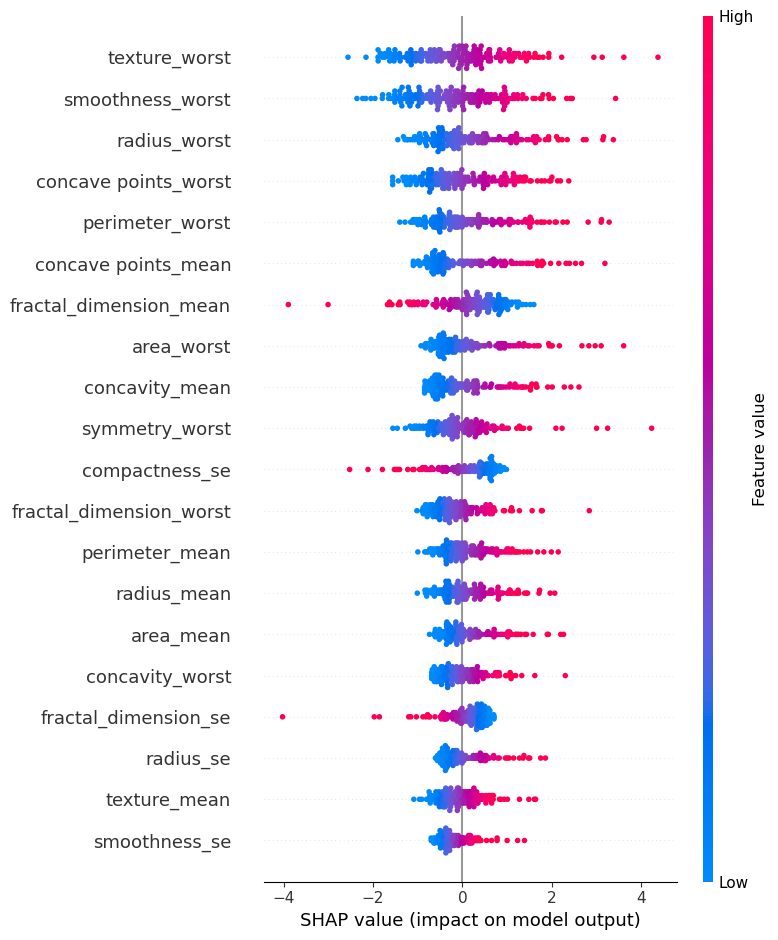

In [97]:

# SHAP summary plot
shap.summary_plot(shap_values_lr, X_test, feature_names=feature_cols, show=False)
plt.tight_layout()
plt.show






<function matplotlib.pyplot.show(close=None, block=None)>

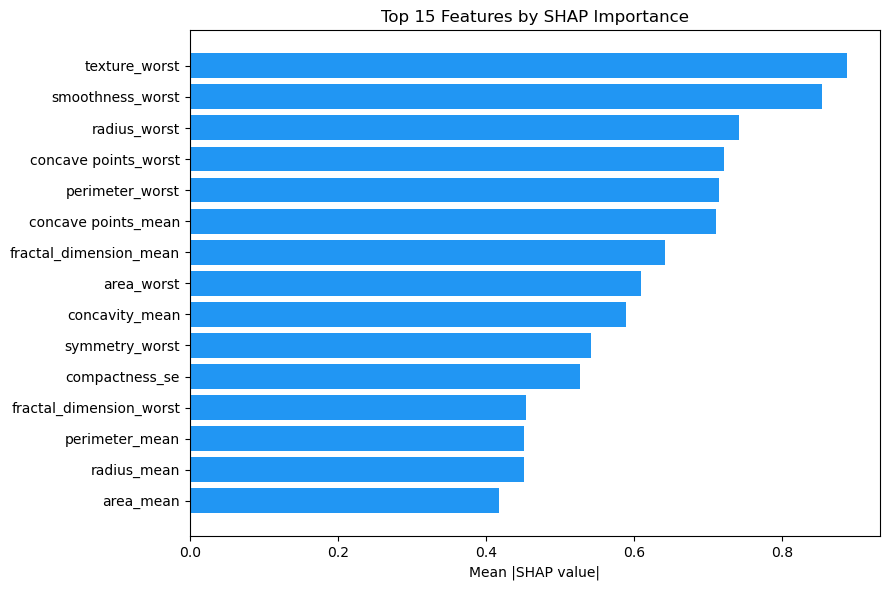

In [96]:

# SHAP Top-15 bar chart
top15 = shap_importance_df.head(15)
plt.figure(figsize=(9, 6))
plt.barh(top15["feature"][::-1], top15["importance"][::-1], color="#2196F3")
plt.xlabel("Mean |SHAP value|")
plt.title("Top 15 Features by SHAP Importance")
plt.tight_layout()
plt.show





In [85]:

# Select Top-10 and Top-5 features
shap_top10 = shap_importance_df.head(10)["feature"].tolist()
shap_top5 = shap_importance_df.head(5)["feature"].tolist()
idx_top10 = [feature_cols.index(f) for f in shap_top10]
idx_top5 = [feature_cols.index(f) for f in shap_top5]




In [86]:

# Retrain LR on Top-10 and Top-5
X_train_top10, X_test_top10 = X_train[:, idx_top10], X_test[:, idx_top10]
X_train_top5, X_test_top5 = X_train[:, idx_top5], X_test[:, idx_top5]

lr_top10 = LogisticRegression(max_iter=1000)
lr_top10.fit(X_train_top10, y_train)
acc_top10 = accuracy_score(y_test, lr_top10.predict(X_test_top10))

lr_top5 = LogisticRegression(max_iter=1000)
lr_top5.fit(X_train_top5, y_train)
acc_top5 = accuracy_score(y_test, lr_top5.predict(X_test_top5))

print(f"Accuracy (SHAP Top 10): {acc_top10:.4f}")
print(f"Accuracy (SHAP Top 5):  {acc_top5:.4f}")


Accuracy (SHAP Top 10): 0.9532
Accuracy (SHAP Top 5):  0.9415


In [87]:

# ============================
# 4) Lasso (L1 Logistic Regression)
# ============================
lasso_lr = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000)
lasso_lr.fit(X_train, y_train)
y_pred_lasso = lasso_lr.predict(X_test)
acc_lasso = accuracy_score(y_test, y_pred_lasso)
print(f"\nLasso Accuracy: {acc_lasso:.4f}")
print(classification_report(y_test, y_pred_lasso))



Lasso Accuracy: 0.9649
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       107
           1       0.98      0.92      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171



In [88]:

# Extract non-zero coefficients
coef = lasso_lr.coef_[0]
lasso_selected_features = [feature_cols[i] for i, c in enumerate(coef) if c != 0]
lasso_selected_coefs = [c for c in coef if c != 0]
print("Lasso Selected Features:", lasso_selected_features)


Lasso Selected Features: ['texture_mean', 'concavity_mean', 'concave points_mean', 'fractal_dimension_mean', 'smoothness_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'concave points_worst', 'symmetry_worst']


<function matplotlib.pyplot.show(close=None, block=None)>

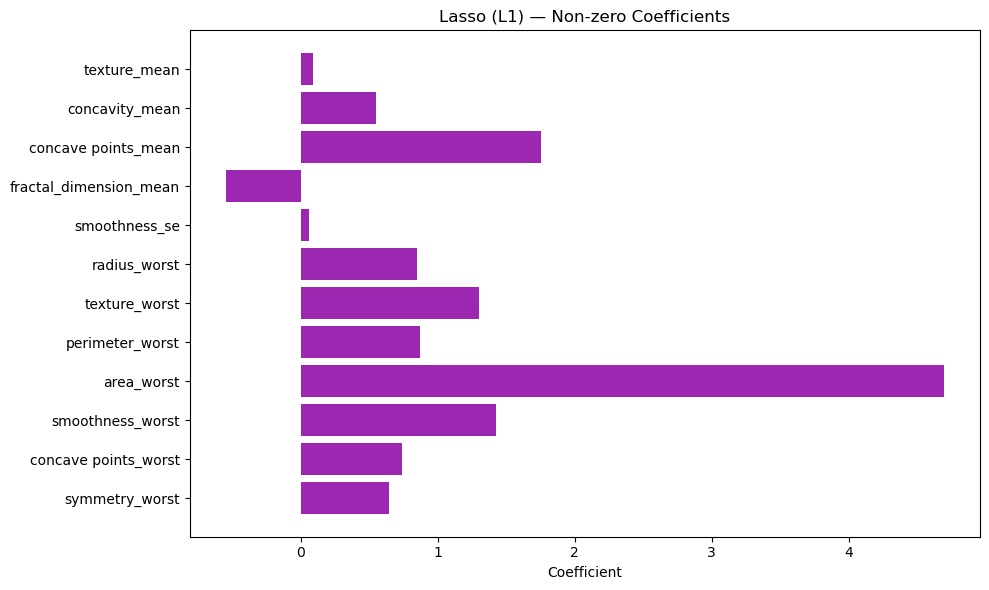

In [94]:

# Lasso coefficient plot
plt.figure(figsize=(10, 6))
plt.barh(lasso_selected_features[::-1], np.array(lasso_selected_coefs)[::-1], color="#9C27B0")
plt.xlabel("Coefficient")
plt.title("Lasso (L1) — Non-zero Coefficients")
plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

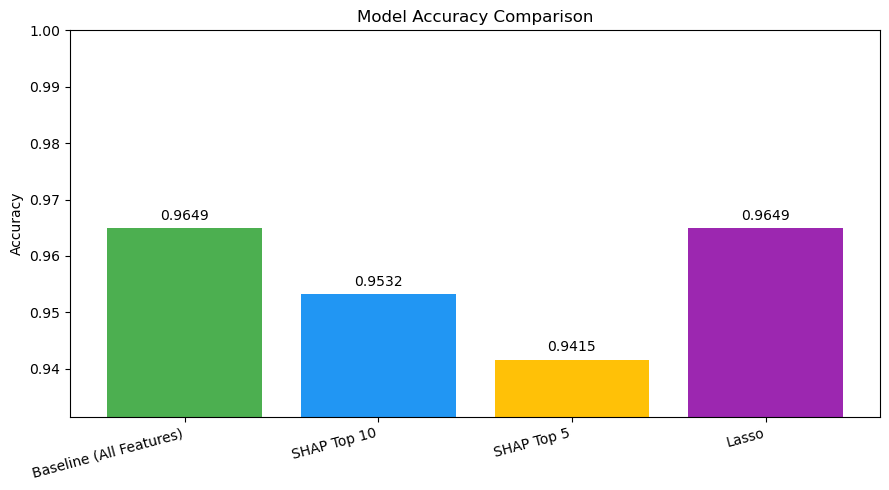

In [93]:

# ============================
# 5) Accuracy Comparison Bar Chart
# ============================
comparison_df = pd.DataFrame({
    "Method": ["Baseline (All Features)", "SHAP Top 10", "SHAP Top 5", "Lasso"],
    "Features": [len(feature_cols), len(shap_top10), len(shap_top5), len(lasso_selected_features)],
    "Accuracy": [acc_lr, acc_top10, acc_top5, acc_lasso]
})

plt.figure(figsize=(9, 5))
colors = ["#4CAF50", "#2196F3", "#FFC107", "#9C27B0"]
plt.bar(comparison_df["Method"], comparison_df["Accuracy"], color=colors)
plt.ylim(max(0.90, comparison_df["Accuracy"].min() - 0.01), 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.xticks(rotation=15, ha="right")
for i, acc in enumerate(comparison_df["Accuracy"]):
    plt.text(i, acc + 0.001, f"{acc:.4f}", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show



SHAP vs Lasso Feature Comparison:

 SHAP Top 5 Features Lasso Selected Features
       texture_worst            texture_mean
    smoothness_worst          concavity_mean
        radius_worst     concave points_mean
concave points_worst  fractal_dimension_mean
     perimeter_worst           smoothness_se
                                radius_worst
                               texture_worst
                             perimeter_worst
                                  area_worst
                            smoothness_worst
                        concave points_worst
                              symmetry_worst


<function matplotlib.pyplot.show(close=None, block=None)>

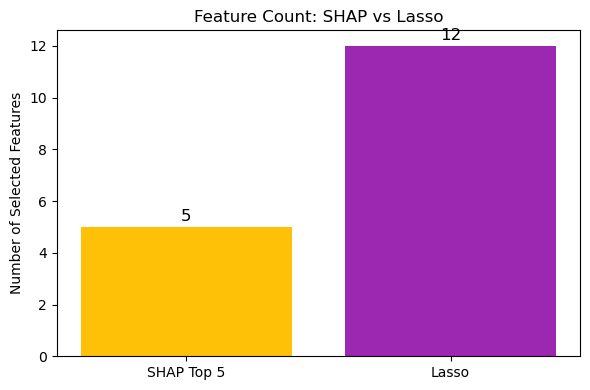

In [92]:

# ============================
# 6) SHAP vs Lasso Feature Comparison
# ============================
max_len = max(len(shap_top5), len(lasso_selected_features))
shap_list = shap_top5 + [""] * (max_len - len(shap_top5))
lasso_list = lasso_selected_features + [""] * (max_len - len(lasso_selected_features))
comparison_features_df = pd.DataFrame({
    "SHAP Top 5 Features": shap_list,
    "Lasso Selected Features": lasso_list
})
print("\nSHAP vs Lasso Feature Comparison:\n")
print(comparison_features_df.to_string(index=False))

plt.figure(figsize=(6, 4))
plt.bar(["SHAP Top 5", "Lasso"], [len(shap_top5), len(lasso_selected_features)], color=["#FFC107", "#9C27B0"])
plt.ylabel("Number of Selected Features")
plt.title("Feature Count: SHAP vs Lasso")
for i, count in enumerate([len(shap_top5), len(lasso_selected_features)]):
    plt.text(i, count + 0.1, str(count), ha="center", va="bottom", fontsize=12)
plt.tight_layout()
plt.show
